Capstone Project (August 2025)

Single Stage Relative Sector Rotation Model

Objective:

To develop and validate a quantitative model that ranks the 11 sector ETFs based on predicted next-month relative performance. The final model will be used to construct a monthly rotating portfolio that aims to outperform benchmarks while managing regime risk.

1. Predict next-month performance of each sector ETFs
2. Rank their relative strength
3. Backtest the strategy to see if it outperforms passive SPY benchmark

Dataset range: 2010-01-01 to present

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import ElasticNet

from scipy import stats
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')
np.NaN = np.nan # this solved issue with pandas_ta
import pandas_ta as ta
from pandas.tseries.offsets import BDay
import pandas_datareader.data as web

In [3]:
# internal function
# checking data quality
def quick_data_check(df, data_name = 'dataset'):
  print(f"{data_name}")
  print(f"Shape of {data_name}: {df.shape}")
  print(f"Data range: {df.index.min()} to {df.index.max()}")
  print(f"Missing values: {df.isnull().sum().sum()}")
  print(f"Columns: {df.columns.tolist()}")
  return df.head(3), df.tail(3)

# creating rolling features
def create_rolling_features(series, windows=[20,60,200]):
  features = {}
  for window in windows:
    features[f'ma_{window}'] = series.rolling(window=window).mean()
    features[f'std_{window}'] = series.rolling(window=window).std()
  return pd.DataFrame(features, index=series.index)

# creating sector features
def create_sector_features(price_series, windows=[20,60,200]):
  features = {}
  for window in windows:
    features[f'sector_ma_{window}'] = price_series.rolling(window=window).mean()
    features[f'sector_std_{window}'] = price_series.rolling(window=window).std()

  features['returns_1m'] = price_series.pct_change(20)
  features['returns_3m'] = price_series.pct_change(60)
  features['volatility_20d'] = price_series.pct_change().rolling(20).std()*np.sqrt(252)
  return pd.DataFrame(features, index=price_series.index)

## Part 1.1

### Data collection and preparation

In [4]:
# data collection
start_date = '2010-01-01'
end_date = datetime.datetime.now().strftime('%Y-%m-%d')
print(f"Collecting data from {start_date} to {end_date}")

sector_etf = {
    'XLE': 'Energy',
    'XLF': 'Financials',
    'XLV': 'Health Care',
    'XLI': 'Industrials',
    'XLB': 'Materials',
    'XLRE': 'Real Estate',
    'XLK': 'Technology',
    'XLC': 'Communication Services',
    'XLY': 'Consumer Discretionary',
    'XLP': 'Consumer Staples',
    'XLU': 'Utilities'
}

benchmark = {
    'SPY': 'S&P 500',
    'SHY': '30-Year Treasury Bill'
}

macro_indicator = {
    '^TNX': '10-Year Treasury',
    'CL=F': 'WTI Crude Oil',
}

In [5]:
# sector ETFs
data = {}
for ticker, name in sector_etf.items():
  print(f"Downloading {ticker} ({name})")
  try:
    ticker_data = yf.download(ticker,
                              start = start_date,
                              end = end_date,
                              progress=False)
    data[ticker] = ticker_data
    print(f"{ticker}: {len(ticker_data)} rows downloaded")
  except Exception as e:
    print(f"Error downloading {ticker}: {e}")

XLE: 3929 rows downloaded
XLF: 3929 rows downloaded
XLV: 3929 rows downloaded
XLI: 3929 rows downloaded
XLB: 3929 rows downloaded
XLRE: 2478 rows downloaded
XLK: 3929 rows downloaded
XLC: 1800 rows downloaded
XLY: 3929 rows downloaded
XLP: 3929 rows downloaded
XLU: 3929 rows downloaded


In [6]:
# benchmarks
for ticker, name in benchmark.items():
  print(f"Downloading {ticker} ({name})")
  try:
    ticker_data = yf.download(ticker,
                              start = start_date,
                              end = end_date,
                              progress=False)
    data[ticker] = ticker_data
    print(f"{ticker}: {len(ticker_data)} rows downloaded")
  except Exception as e:
    print(f"Error downloading {ticker}: {e}")

SPY: 3929 rows downloaded
SHY: 3929 rows downloaded


In [7]:
# macro indicators
for ticker, name in macro_indicator.items():
  print(f"Downloading {ticker} ({name})")
  try:
    ticker_data = yf.download(ticker,
                              start = start_date,
                              end = end_date,
                              progress=False)
    data[ticker] = ticker_data
    print(f"{ticker}: {len(ticker_data)} rows downloaded")
  except Exception as e:
    print(f"Error downloading {ticker}: {e}")

print(f"Total number of datasets: {len(data)}")
print(f"List of datasets: {list(data.keys())}")

^TNX: 3927 rows downloaded
CL=F: 3929 rows downloaded
Total number of datasets: 15
List of datasets: ['XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLC', 'XLY', 'XLP', 'XLU', 'SPY', 'SHY', '^TNX', 'CL=F']


In [8]:
# extract adjusted close
adj_close_prices = {}
for ticker, ticker_data in data.items():
    adj_close_prices[ticker] = ticker_data[('Close', ticker)]

# create DataFrame
df_data = pd.DataFrame(adj_close_prices)

# validate dataset
#quick_data_check(df_data, "Combined Price Data")

In [9]:
# missing data analysis
missing_val = df_data.isnull().sum().sort_values(ascending=False)
print(f"Missing values: \n{missing_val}\n")

for ticker in df_data.columns:
  print(f"{ticker}: {df_data[ticker].first_valid_index()}")

Missing values: 
XLC     2131
XLRE    1453
^TNX       4
XLE        2
XLF        2
XLV        2
XLI        2
XLB        2
XLK        2
XLY        2
XLP        2
XLU        2
SPY        2
SHY        2
CL=F       2
dtype: int64

XLE: 2010-01-04 00:00:00
XLF: 2010-01-04 00:00:00
XLV: 2010-01-04 00:00:00
XLI: 2010-01-04 00:00:00
XLB: 2010-01-04 00:00:00
XLRE: 2015-10-08 00:00:00
XLK: 2010-01-04 00:00:00
XLC: 2018-06-19 00:00:00
XLY: 2010-01-04 00:00:00
XLP: 2010-01-04 00:00:00
XLU: 2010-01-04 00:00:00
SPY: 2010-01-04 00:00:00
SHY: 2010-01-04 00:00:00
^TNX: 2010-01-04 00:00:00
CL=F: 2010-01-04 00:00:00


## Part 1.2

### Missing data (XLC, XLRE)

2 sector ETFs launched later than the other 9 ETFs and thus have missing data.
- XLRE: launched 2015-10-08
 - real estate ETF existed before 2015 will be used as proxy for XLRE
- XLC: launched 2018-06-19
 - top 10 holdings of XLC will be used as proxy for XLC before 2018

In [10]:
# checking real estate ETFs availability
real_estate = ['VNQ','IYR','FREL','SCHH']
available_etf = []

for etf in real_estate:
  try:
    test_data = yf.download(etf,
                            start = '2010-01-01',
                            end = '2015-10-07',
                            progress=False)
    if not test_data.empty:
      available_etf.append(etf)
      print(f"{etf}: available from {test_data.index.date.min()}")
    else:
      print(f"{etf}: not available")
  except Exception as e:
    print(f"Error downloading {etf}: {e}")

VNQ: available from 2010-01-04
IYR: available from 2010-01-04
FREL: available from 2015-02-05
SCHH: available from 2011-01-13


In [11]:
# choose between VNQ and IYR by comparing correlation with XLRE
vnq = yf.download('VNQ',
                  start = '2015-10-07',
                  end = '2025-01-01',
                  progress=False)
iyr = yf.download('IYR',
                  start = '2015-10-07',
                  end = '2025-01-01',
                  progress=False)
xlre = yf.download('XLRE',
                  start = '2015-10-07',
                  end = '2025-01-01',
                  progress=False)

vnq_close = vnq['Close','VNQ']
iyr_close = iyr['Close','IYR']
xlre = df_data['XLRE'].loc['2015-10-07':'2025-01-01'].dropna()

vnq_corr = vnq_close.corr(xlre)
iyr_corr = iyr_close.corr(xlre)

print(f"Correlation between VNQ and XLRE: {vnq_corr:.3f}")
print(f"Correlation between IYR and XLRE: {iyr_corr:.3f}")

vnq_return = vnq_close.pct_change().dropna()
iyr_retutrn = iyr_close.pct_change().dropna()
xlre_return = xlre.pct_change().dropna()

vnq_ret_corr = vnq_return.corr(xlre_return)
iyr_ret_corr = iyr_retutrn.corr(xlre_return)

print(f"Correlation between VNQ returns and XLRE returns: {vnq_ret_corr:.3f}")
print(f"Correlation between IYR returns and XLRE returns: {iyr_ret_corr:.3f}")

print(f"Using IYR as proxy for XLRE")

Correlation between VNQ and XLRE: 0.988
Correlation between IYR and XLRE: 0.991
Correlation between VNQ returns and XLRE returns: 0.976
Correlation between IYR returns and XLRE returns: 0.978
Using IYR as proxy for XLRE


In [12]:
# first day XLRE existed
stitch_date_xlre = '2015-10-08'

# proxy data up to (but not including) the stitch date
iyr_prices = yf.download("IYR", start='2010-01-01', end=stitch_date_xlre, progress=False)['Close'].squeeze()

# real data from the stitch date onwards
xlre_prices = yf.download("XLRE", start=stitch_date_xlre, end=end_date, progress=False)['Close'].squeeze()

# scaling factor
scaling_factor_xlre = xlre_prices.iloc[0] / iyr_prices.iloc[-1]

# scaling the entire proxy history
scaled_iyr_history = iyr_prices * scaling_factor_xlre

# result XLRE
continuous_xlre = pd.concat([
    scaled_iyr_history,
    xlre_prices
])

df_data['XLRE'] = continuous_xlre

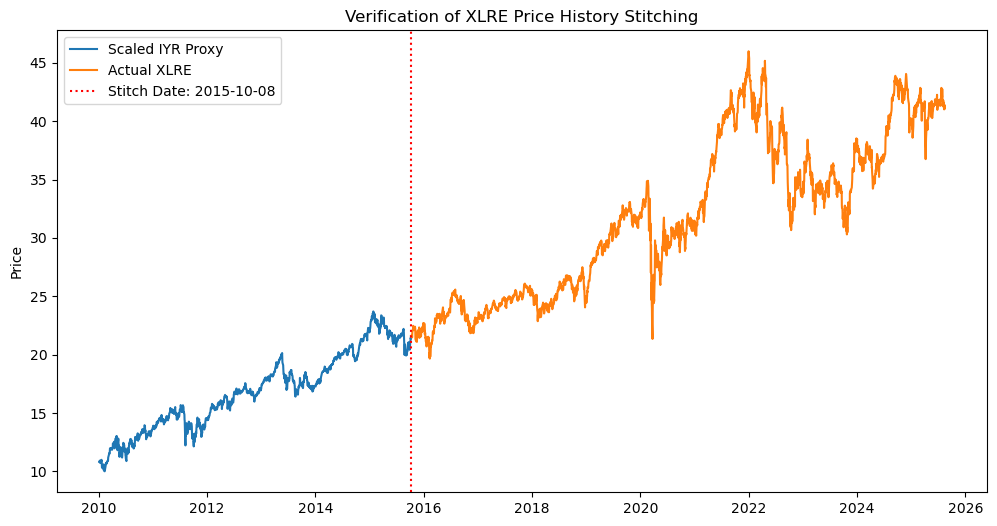

In [13]:
# XLRE stitching verification plot
plt.figure(figsize=(12,6))
plt.plot(scaled_iyr_history, label='Scaled IYR Proxy')
plt.plot(xlre_prices, label='Actual XLRE')
plt.axvline(pd.to_datetime(stitch_date_xlre), color='red', linestyle=':',
            label=f'Stitch Date: {stitch_date_xlre}')
plt.title('Verification of XLRE Price History Stitching')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
# checking telecommunication ETFs availability
tele_comm = ['FCOM','VOX','IYZ']
available_etf = []

for etf in tele_comm:
  try:
    test_data = yf.download(etf,
                            start = '2010-01-01',
                            end = '2018-06-19',
                            progress=False)
    if not test_data.empty:
      available_etf.append(etf)
      print(f"{etf}: available from {test_data.index.date.min()}")
    else:
      print(f"{etf}: not available")
  except Exception as e:
    print(f"Error downloading {etf}: {e}")

FCOM: available from 2013-10-24
VOX: available from 2010-01-04
IYZ: available from 2010-01-04


In [15]:
# choose between VOX and IYZ by comparing correlation with XLRE
vox = yf.download('VOX',
                  start = '2018-06-18',
                  end = '2025-01-01',
                  progress=False)
iyz = yf.download('IYZ',
                  start = '2018-06-18',
                  end = '2025-01-01',
                  progress=False)
xlc = yf.download('XLC',
                  start = '2018-06-18',
                  end = '2025-01-01',
                  progress=False)

vox_close = vox['Close','VOX']
iyz_close = iyz['Close','IYZ']
xlc = df_data['XLC'].loc['2018-06-18':'2025-01-01'].dropna()

vox_corr = vox_close.corr(xlc)
iyz_corr = iyz_close.corr(xlc)

print(f"Correlation between VOX and XLC: {vox_corr:.3f}")
print(f"Correlation between IYZ and XLC: {iyz_corr:.3f}")

vox_return = vox_close.pct_change().dropna()
iyz_return = iyz_close.pct_change().dropna()
xlc_return = xlc.pct_change().dropna()

vox_ret_corr = vox_return.corr(xlc_return)
iyz_ret_corr = iyz_return.corr(xlc_return)

print(f"Correlation between VOX returns and XLC returns: {vox_ret_corr:.3f}")
print(f"Correlation between IYZ returns and XLC returns: {iyz_ret_corr:.3f}")

print(f"Using VOX as proxy for XLC")

Correlation between VOX and XLC: 0.986
Correlation between IYZ and XLC: 0.236
Correlation between VOX returns and XLC returns: 0.987
Correlation between IYZ returns and XLC returns: 0.767
Using VOX as proxy for XLC


In [16]:
# scaling proxy etfs to mathc XLC price

# first day XLC existed
stitch_date_xlc = '2018-06-19'

# proxy data up to (but not including) the stitch date
vox_prices = yf.download("VOX", start='2010-01-01', end=stitch_date_xlc, progress=False)['Close'].squeeze()

# real data from the stitch date onwards
xlc_prices = yf.download("XLC", start=stitch_date_xlc, end=end_date, progress=False)['Close'].squeeze()

# scaling using the last day of the proxy and first day of the real asset
scaling_factor_xlc = xlc_prices.iloc[0] / vox_prices.iloc[-1]

# scaling the entire proxy history
scaled_vox_history = vox_prices * scaling_factor_xlc

# result XLC
continuous_xlc = pd.concat([
    scaled_vox_history,
    xlc_prices
])

df_data['XLC'] = continuous_xlc

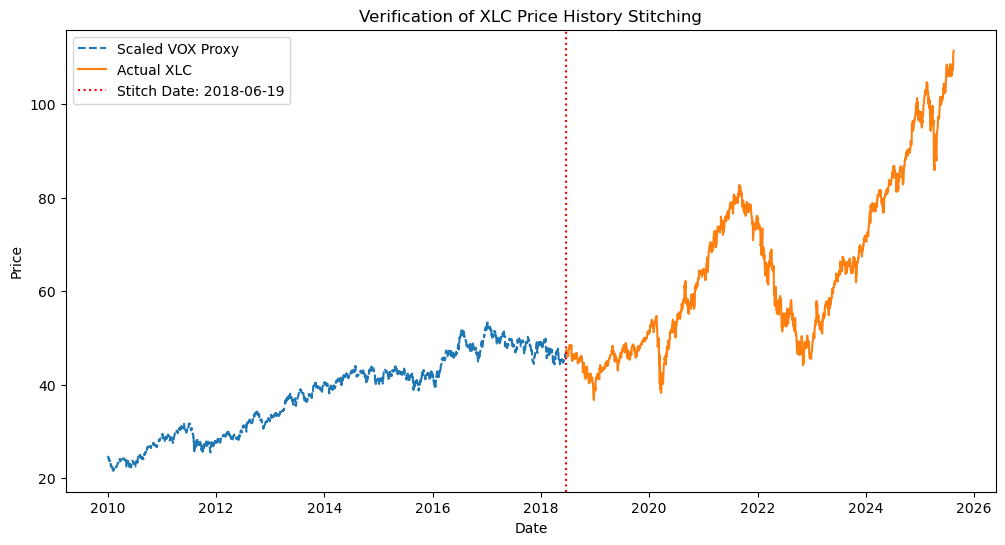

In [17]:
# XLC stitching verification plot
plt.figure(figsize=(12,6))
plt.plot(scaled_vox_history, label='Scaled VOX Proxy', linestyle='--')
plt.plot(xlc_prices, label='Actual XLC')
plt.axvline(pd.to_datetime(stitch_date_xlc), color='red', linestyle=':',
            label=f'Stitch Date: {stitch_date_xlc}')
plt.title('Verification of XLC Price History Stitching')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
# high yield credit spread (risk premium)
# difference between safer bonds and junk bonds
start_date_fred = datetime.datetime(2010,1,1)
end_date_fred = datetime.datetime.now()


# download the data from FRED using series ID
fred_data = web.DataReader('BAMLH0A0HYM2', 'fred', start_date_fred, end_date_fred)
fred_data.rename(columns={'BAMLH0A0HYM2': 'HY_SPREAD'}, inplace=True)

df_data = df_data.merge(fred_data, left_index=True, right_index=True, how='left')

In [19]:
# check combined data
quick_data_check(df_data, "Combined Price Data")

Combined Price Data
Shape of Combined Price Data: (3931, 16)
Data range: 2010-01-04 00:00:00 to 2025-08-15 00:00:00
Missing values: 35
Columns: ['XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLC', 'XLY', 'XLP', 'XLU', 'SPY', 'SHY', '^TNX', 'CL=F', 'HY_SPREAD']


(                  XLE       XLF        XLV        XLI        XLB       XLRE  \
 Date                                                                          
 2010-01-04  35.357681  9.049464  24.296616  21.140423  24.379665  10.800107   
 2010-01-05  35.646278  9.215793  24.058334  21.215073  24.458483  10.826040   
 2010-01-06  36.073132  9.234270  24.304304  21.259855  24.874132  10.821328   
 
                   XLK        XLC        XLY        XLP        XLU        SPY  \
 Date                                                                           
 2010-01-04  18.833546  24.414903  24.759159  17.607046  18.151886  85.515602   
 2010-01-05  18.809275  24.579863  24.849947  17.613653  17.935789  85.742012   
 2010-01-06  18.598839  24.190716  24.882959  17.600451  18.040918  85.802383   
 
                   SHY   ^TNX       CL=F  HY_SPREAD  
 Date                                                
 2010-01-04  67.625771  3.841  81.510002       6.34  
 2010-01-05  67.707161  3.755

In [20]:
# preserve the raw data
df_data.to_csv('sector_rotation_raw.csv')

## Part 2-1

### Feature set engineering

Feature category
- Sector focused (4 features per sector)
    - Monemtum features: 63-day average return, 252-day average return
        - Momentum effects in equity markets suggest sectors with recent outperformance tend to continue outperforming in the short term due to investor herding and delayed information processing
    - Volatility feature: 63-day volatility
        - Risk-adjusted returns help identify sectors offering better compensation per risk, which preferred duing portfolio allocation by investors
    - Sharpe ratio: 63-day average return / 63-day volatility
- Macro focused (4 features on whole dataset)
    - SPY vs. its 200-day moving average (Market regine indicator)
        - Sector rotation strategies typically work better in trending markets vs. sideway markets
    - 63-day oil price momentum
        - Energy sector correlation with oil prices creates spillover effects across sectors such as materials and industrials
    - Interest rate (10 year yield)
    - High yield credit spread
        - During stress periods, investors flee to defensive sectors rather than cyclical sectors
- Relative strength feature: sector ranking based on performance per month
    - Cross-sectional momentum
        - Sectors performing well relative to peers tend to continue outperforming

In [21]:
# load and check duplicates
df = pd.read_csv('sector_rotation_raw.csv')

print(f"Total rows: {len(df)}")
print(f"Unique dates: {df['Date'].nunique()}")

duplicate_dates = df[df['Date'].duplicated(keep=False)]
if not duplicate_dates.empty:
    print(duplicate_dates[['Date']].sort_values('Date'))

Total rows: 3931
Unique dates: 3931


In [22]:
# prepare dataset
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

sectors = ['XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE',
           'XLK', 'XLC', 'XLY', 'XLP', 'XLU']

In [23]:
def create_feature_a(df, sectors):
  features_df = pd.DataFrame(index=df.index)

  for sector in sectors:
    prices = df[sector]
    returns = prices.pct_change()
    # return 63 days (3 month momentum)
    features_df[f'{sector}_return_63d'] = prices.pct_change(63)
    # return 252 days (1 year trend)
    features_df[f'{sector}_return_252d'] = prices.pct_change(252)
    # volatility 63 days (3 month volatility)
    features_df[f'{sector}_volatility_63d'] = returns.rolling(63).std() * np.sqrt(252)

    rolling_return = returns.rolling(63).mean()*252
    rolling_vol = returns.rolling(63).std()*np.sqrt(252)
    # sharpe 63 days (risk adjusted return)
    features_df[f'{sector}_sharpe_63d'] = rolling_return / rolling_vol

  # ranking by return 63 days (cross sectional relative strength)
  return_63d_cols = [col for col in features_df.columns if 'return_63d' in col]
  rank_df = features_df[return_63d_cols].rank(axis=1, method='min')
  for i, sector in enumerate(sectors):
    if f'{sector}_return_63d' in rank_df.columns:
      features_df[f'{sector}_rank_return_63d'] = rank_df[f'{sector}_return_63d']

  spy_200ma = df['SPY'].rolling(200).mean()
  # regime filter (if spy was above 200 day ma)
  features_df['spy_above_200ma'] = (df['SPY'] > spy_200ma).astype(int)
  # energy sector specifiec feature (oil price momentum)
  features_df['oil_price_momentum_63d'] = df['CL=F'].pct_change(63)
  # interest rate level
  features_df['treasury_10y_level'] = df['^TNX']
  # high yield credit spread (credit risk measure)
  features_df['hy_credit_spread'] = df['HY_SPREAD']

  return features_df

In [24]:
features_a = create_feature_a(df, sectors)

#quick_data_check(features_a, "Feature Set A")

In [25]:
features_a.to_csv('features_set_a.csv')

- feature set B will be mentioned in future work/steps

## Part 2-1-1

### Exploratory data analysis: Features

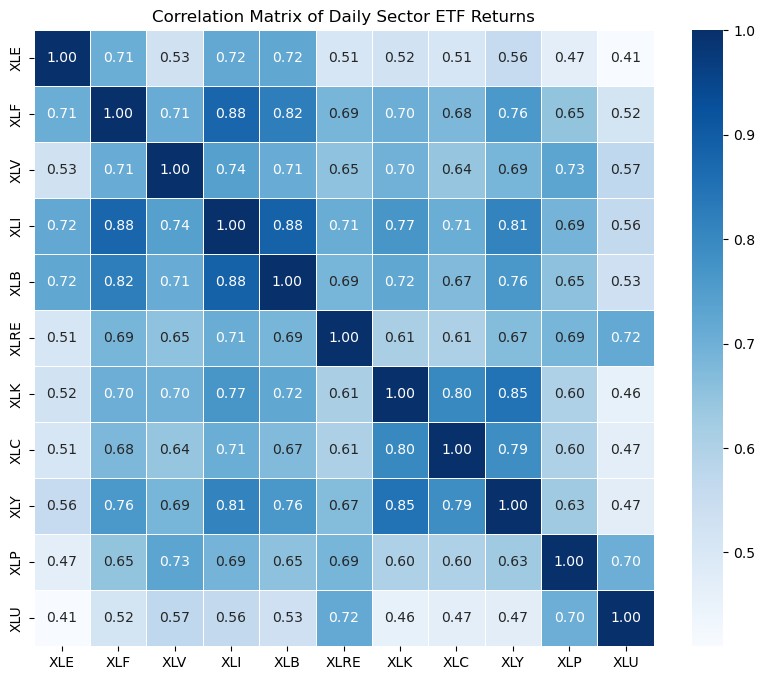

In [26]:
# correlation heatmap

sector_returns = df[sectors].pct_change().dropna()
corr_mat = sector_returns.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True, cmap='Blues', fmt='.2f', linewidth=.5)
plt.title('Correlation Matrix of Daily Sector ETF Returns')
plt.show()

In [27]:
# average sector correlation (daily returns)
mean_corr = (corr_mat.sum()-1)/(len(sectors)-1)
print(f"Mean correlation: \n{mean_corr.round(3).sort_values(ascending=True)}")

Mean correlation: 
XLU     0.542
XLE     0.565
XLP     0.642
XLC     0.648
XLRE    0.654
XLV     0.668
XLK     0.674
XLY     0.700
XLF     0.712
XLB     0.718
XLI     0.748
dtype: float64


- All sectors are moderately to highly correlated with each other.
- Most sectors move in the same direction.
- Predictng relative sector performance is likely to be difficult.
- Combining less correlated assets might reduce overall risk. if one sector goes down, less correlated sectors are less likely to follow.
- Future strategy could attempt to rotate between defensive and cyclical sectors such as XLU, XLP, XLE, XLK, and XLI.

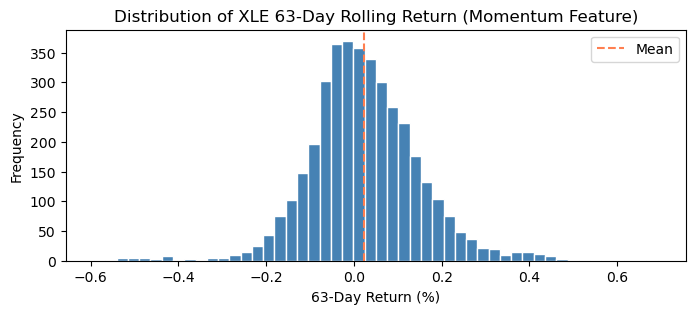

In [28]:
# feature distribution (XLE 63-day return)
plt.figure(figsize=(8,3))
plt.hist(features_a['XLE_return_63d'].dropna(), bins=50,
         color='steelblue', edgecolor='white')
plt.title('Distribution of XLE 63-Day Rolling Return (Momentum Feature)')
plt.xlabel('63-Day Return (%)')
plt.ylabel('Frequency')
plt.axvline(features_a['XLE_return_63d'].mean(), color='coral',
            linestyle='--', label='Mean')
plt.legend()
plt.show()


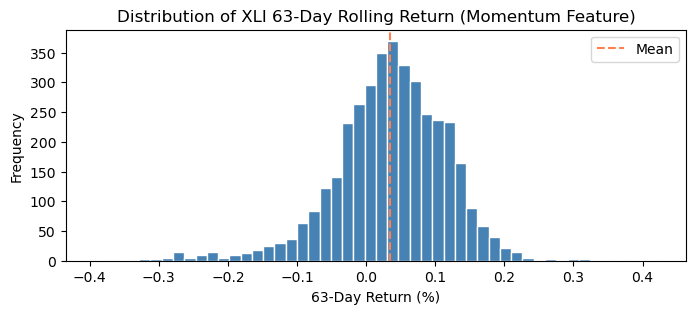

In [29]:
# feature distribution (XLI 63-day return)
plt.figure(figsize=(8,3))
plt.hist(features_a['XLI_return_63d'].dropna(), bins=50,
         color='steelblue', edgecolor='white')
#sns.histplot(features_a['XLE_return_63d'].dropna(), kde=True, bins=50,color='steelblue')
plt.title('Distribution of XLI 63-Day Rolling Return (Momentum Feature)')
plt.xlabel('63-Day Return (%)')
plt.ylabel('Frequency')
plt.axvline(features_a['XLI_return_63d'].mean(), color='coral',
            linestyle='--', label='Mean')
plt.legend()
plt.show()

- XLE: Lower correlation due to its own unique and highly volatile factors like oil prices. this creates the potential for much wider and more extreme return swings.
- XLI: Highly correlated sector and returns are more in-line with the general market. results in a tighter and more predictable distribution of returns

## Part 2-2

### Target engineering

Target variable
- 21-day forward log return per sector: Monthly return was chosen to avoid market noise 

In [30]:
# 21 day forward log returns for each sector
def create_forward_return(df, sectors):
  target_df = pd.DataFrame(index=df.index)
  for sector in sectors:
    if sector in df.columns:
      # 21 day forward log returns
      future_price = df[sector].shift(-21)
      current_price = df[sector]
      # log returns
      target_df[f'{sector}_return_21d_forward'] = np.log(future_price / current_price)

  return target_df

In [31]:
targets = create_forward_return(df, sectors)

#quick_data_check(targets, "Target Set")

## Part 3-1

### Dataset preparation

In [32]:
# merging features and targets
features_a['Date'] = pd.to_datetime(features_a.index)
features_a.set_index('Date', inplace=True)
targets['Date'] = pd.to_datetime(targets.index)
targets.set_index('Date', inplace=True)

data_a = features_a.merge(targets, left_index=True, right_index=True, how='inner')

print(f"Features A shape: {data_a.shape}")
print(f"Data A shape: {data_a.shape}")

Features A shape: (3931, 70)
Data A shape: (3931, 70)


In [33]:
# checking infinite values
numeric_cols = data_a.select_dtypes(include=[np.number]).columns
inf_ct = []
for col in numeric_cols:
  if data_a[col].isin([np.inf, -np.inf]).any():
    inf_ct.append(col)
print(f"Infinite values: {inf_ct}")
if not inf_ct:
  print("No infinite values")

Infinite values: []
No infinite values


In [34]:
# checking outliers
for col in numeric_cols:
  q1 = data_a[col].quantile(.01)
  q99 = data_a[col].quantile(.99)
  outlier_low = (data_a[col] < q1).sum()
  outlier_high = (data_a[col] > q99).sum()
  total_outliers = outlier_low + outlier_high
  if total_outliers > 0:
    print(f"{col}: {total_outliers} outliers")
  else:
    print(f"{col}: no outliers")

XLE_return_63d: 78 outliers
XLE_return_252d: 74 outliers
XLE_volatility_63d: 78 outliers
XLE_sharpe_63d: 78 outliers
XLF_return_63d: 78 outliers
XLF_return_252d: 74 outliers
XLF_volatility_63d: 78 outliers
XLF_sharpe_63d: 78 outliers
XLV_return_63d: 78 outliers
XLV_return_252d: 74 outliers
XLV_volatility_63d: 78 outliers
XLV_sharpe_63d: 78 outliers
XLI_return_63d: 78 outliers
XLI_return_252d: 74 outliers
XLI_volatility_63d: 78 outliers
XLI_sharpe_63d: 78 outliers
XLB_return_63d: 78 outliers
XLB_return_252d: 74 outliers
XLB_volatility_63d: 78 outliers
XLB_sharpe_63d: 78 outliers
XLRE_return_63d: 78 outliers
XLRE_return_252d: 74 outliers
XLRE_volatility_63d: 78 outliers
XLRE_sharpe_63d: 78 outliers
XLK_return_63d: 78 outliers
XLK_return_252d: 74 outliers
XLK_volatility_63d: 78 outliers
XLK_sharpe_63d: 78 outliers
XLC_return_63d: 78 outliers
XLC_return_252d: 74 outliers
XLC_volatility_63d: 78 outliers
XLC_sharpe_63d: 78 outliers
XLY_return_63d: 78 outliers
XLY_return_252d: 74 outliers
XLY

In [35]:
q1 = data_a['XLE_return_63d'].quantile(.01)
q99 = data_a['XLE_return_63d'].quantile(.99)
print(f"Max loss: {q1}")
print(f"Max gain: {q99}")

outlier_mask = (data_a['XLE_return_63d'] < q1) | (data_a['XLE_return_63d'] > q99)
outliers_dates = data_a[outlier_mask].index
print(f"Outliers dates: \n{outliers_dates}")

Max loss: -0.3261607365437319
Max gain: 0.39440936795625076
Outliers dates: 
DatetimeIndex(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-16', '2020-03-17', '2020-03-18',
               '2020-03-19', '2020-03-20', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-30',
               '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
               '2020-04-17', '2020-04-20', '2020-04-21', '2020-04-22',
               '2020-04-23', '2020-04-24', '2020-04-27', '2020-04-28',
               '2020-05-06', '2020-05-13', '2020-05-14', '2020-06-08',
               '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-19', '2020-06-22', '2020-06-23', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-19',


- Outlier dates are valid ones.
- In March-June 2020, market experienced COVID crash and recovery
- In early 2021, market volatility went up with GameStop and meme stock boom
- In March-April 2022, Russia invaded Ukraine provoking inflation fears

In [36]:
# missing values
missing_ct = data_a.isnull().sum().sort_values(ascending=False)
print(f"Missing values: \n{missing_ct}\n")
missing_pct = missing_ct / len(data_a) * 100
print(f"Missing values percentage: \n{missing_pct}\n")

Missing values: 
XLY_return_252d           252
XLP_return_252d           252
XLU_return_252d           252
XLRE_return_252d          252
XLI_return_252d           252
                         ... 
XLF_return_21d_forward     25
XLE_return_21d_forward     25
treasury_10y_level          4
hy_credit_spread            3
spy_above_200ma             0
Length: 70, dtype: int64

Missing values percentage: 
XLY_return_252d           6.410583
XLP_return_252d           6.410583
XLU_return_252d           6.410583
XLRE_return_252d          6.410583
XLI_return_252d           6.410583
                            ...   
XLF_return_21d_forward    0.635970
XLE_return_21d_forward    0.635970
treasury_10y_level        0.101755
hy_credit_spread          0.076316
spy_above_200ma           0.000000
Length: 70, dtype: float64



In [37]:
total_missing = missing_ct.sum()
print(f"Total missing values: {total_missing}")
print(f"Total cells in dataset: {len(data_a) * len(data_a.columns)}")
print(f"Percentage of missing values: {total_missing / (len(data_a) * len(data_a.columns)) * 100}")

Total missing values: 5889
Total cells in dataset: 275170
Percentage of missing values: 2.1401315550387037


In [38]:
# forward filling missing values up to 5 days
# assuming the last known price persists until new information arrives
data_a_filled = data_a.fillna(method='ffill', limit=5)
print(f"Missing values before forward-fill: {total_missing}")
print(f"Missing values after forward-fill: {data_a_filled.isnull().sum().sum()}")

Missing values before forward-fill: 5889
Missing values after forward-fill: 5783


In [39]:
df_clean = data_a_filled.dropna()
print(f"Before cleaning: {data_a_filled.shape}")
print(f"After cleaning: {df_clean.shape}")
print(f"Data range: {df_clean.index.date.min()} to {df_clean.index.date.max()}")

Before cleaning: (3931, 70)
After cleaning: (3663, 70)
Data range: 2011-01-03 to 2025-07-24


## Part 3-2

### Timeline setup

A strict T-2 timeline will be used to prevent look-ahead bias.
- Predictions are generated two days before month end and trades are executed on the last trading day of the month.

In [40]:
month_ends = df_clean.resample('BM').last().index
t2_dates = month_ends - pd.tseries.offsets.BDay(2)
df_t2 = df_clean.loc[df_clean.index.isin(t2_dates)]

print(f"Original datast: {len(df_clean)} observations")
print(f"T-2 dataset: {len(df_t2)} observations")
print(f"Date range: {df_t2.index.date.min()} to {df_t2.index.date.max()}")

Original datast: 3663 observations
T-2 dataset: 169 observations
Date range: 2011-01-27 to 2025-06-26


## Part 3-3

### Walk forward validation

- The model will be tested using an expanding window, retrained monthly, with a minimum initial training period of 36 months.
- The model will be always tested on unseen data.

In [41]:
# minimum training window = 36 months
min_train_month = 36
start_idx = min_train_month - 1

# walk forward validation
results = []
for i in range(start_idx, len(df_t2)):
  # expanding window from start to current by 1 month
  train_data = df_t2.iloc[:i+1]

  # next month
  if i + 1 < len(df_t2):
    test_data = df_t2.iloc[i+1:i+2]
    results.append({
        'train_end': train_data.index.date[-1],
        'test_date': test_data.index.date[0],
        'train_size': len(train_data)
    })

print(f"Total prediction: {len(results)}")
print(f"First prediction: {results[0]['test_date']}")
print(f"Last prediction: {results[-1]['test_date']}")

Total prediction: 133
First prediction: 2014-02-26
Last prediction: 2025-06-26


- 1st prediction: Train on 36 months (2011-2014), predict Feb 2014
- 2nd prediction: Train on 37 months (2011-2014), predict Mar 2014
- continues as long as data is available

In [42]:
results_df = pd.DataFrame(results)
results_df.to_csv('data_a_wf_df.csv')

## Part 4-1

### Random Forest Model

In [43]:
# random forest
# separating target and features
feature_cols = [col for col in df_t2.columns if not col.endswith('_return_21d_forward')]
target_cols = [col for col in df_t2.columns if col.endswith('_return_21d_forward')]

rf_mod = RandomForestRegressor(n_estimators=100,
                               random_state=42,
                               max_depth=3)
scaler = StandardScaler()
rf_pred = []

for i, result in enumerate(results):
  # training data
  train_data = df_t2.iloc[:start_idx + i + 1]
  X_train = scaler.fit_transform(train_data[feature_cols])
  y_train = train_data[target_cols].values

  # testing data
  test_data = df_t2.iloc[start_idx + i + 1:start_idx + i + 2]
  X_test = scaler.transform(test_data[feature_cols])

  # predict
  rf_mod.fit(X_train, y_train)
  pred = rf_mod.predict(X_test)

  # results
  sector_dict = dict(zip([col.replace('_return_21d_forward','') for col in target_cols], pred[0]))
  rf_pred.append({'date': result['test_date'], **sector_dict})

print(f"Total predictions: {len(rf_pred)}")
print(f"First prediction: {rf_pred[0]['date']}")
print(f"Last prediction: {rf_pred[-1]['date']}")

Total predictions: 133
First prediction: 2014-02-26
Last prediction: 2025-06-26


In [44]:
# rankings
rf_pred_df = pd.DataFrame(rf_pred)
rf_pred_df.set_index('date', inplace=True)

rf_rankings = rf_pred_df.rank(axis=1, ascending=False)

print("Sample predictions:")
print(rf_pred_df.head(3))
print("\nSample rankings:")
print(rf_rankings.head(3))

Sample predictions:
                 XLE       XLF       XLV       XLI       XLB      XLRE  \
date                                                                     
2014-02-26  0.017537  0.017111  0.027944  0.018377  0.017181  0.020553   
2014-03-27 -0.002770  0.001617  0.013023 -0.000272 -0.000079  0.003433   
2014-04-28  0.015916  0.012279  0.014528  0.010851  0.010424  0.011242   

                 XLK       XLC       XLY       XLP       XLU  
date                                                          
2014-02-26  0.015249  0.013559  0.023961  0.017225  0.018464  
2014-03-27  0.002183  0.006495  0.004612  0.012301  0.013093  
2014-04-28  0.009453  0.010726  0.011774  0.014369  0.014479  

Sample rankings:
             XLE  XLF  XLV   XLI   XLB  XLRE   XLK   XLC  XLY  XLP  XLU
date                                                                   
2014-02-26   6.0  9.0  1.0   5.0   8.0   3.0  10.0  11.0  2.0  7.0  4.0
2014-03-27  11.0  8.0  2.0  10.0   9.0   6.0   7.0   4.0  5.

In [45]:
# actual returns
actual_returns_df = df_t2[target_cols].copy()
actual_returns_df.columns = [col.replace('_return_21d_forward','') for col in target_cols]
actual_returns_df = actual_returns_df.loc[rf_pred_df.index]
actual_returns_rankings = actual_returns_df.rank(axis=1, ascending=False)

print("Actual returns:")
print(actual_returns_df.head(3))
print("\nActual rankings:")
print(actual_returns_rankings.head(3))

Actual returns:
                 XLE       XLF       XLV       XLI       XLB      XLRE  \
date                                                                     
2014-02-26  0.014502  0.028528 -0.016542 -0.001671  0.001836 -0.005315   
2014-03-27  0.059902 -0.013717 -0.003459  0.022910  0.010920  0.037153   
2014-04-28  0.012556  0.021408  0.024469  0.024999  0.034327  0.026460   

                 XLK       XLC       XLY       XLP       XLU  
date                                                          
2014-02-26  0.001791  0.048506 -0.035295  0.023290  0.025042  
2014-03-27  0.004443 -0.018565 -0.008184  0.037966  0.056263  
2014-04-28  0.039924  0.052055  0.032188  0.001128 -0.022882  

Actual rankings:
            XLE   XLF   XLV  XLI  XLB  XLRE  XLK   XLC   XLY   XLP   XLU
date                                                                    
2014-02-26  5.0   2.0  10.0  8.0  6.0   9.0  7.0   1.0  11.0   4.0   3.0
2014-03-27  1.0  10.0   8.0  5.0  6.0   4.0  7.0  11.0   9.0 

In [46]:
rank_corr = rf_rankings.corrwith(actual_returns_rankings, axis=1).mean()
print(f"Rank correlation: {rank_corr.mean()*100:.3f}") # no predictive power

Rank correlation: 6.090


In [47]:
# random forest accuracy
# % of time top 3 predicted match actual top 3
def calculate_top3_accuracy(pred_rankings, actual_rankings):
  top3_matches = 0
  total_predictions = len(pred_rankings)
  for i in range(len(rf_rankings)):
    # top 3 predicted sectors
    pred_top3 = set(rf_rankings.iloc[i].nsmallest(3).index)
    # top 3 actual sectors
    actual_top3 = set(actual_returns_rankings.iloc[i].nsmallest(3).index)

    overlap = len(set(pred_top3) & set(actual_top3))
    top3_matches += overlap / 3

  return top3_matches / total_predictions

rf_accuracy = calculate_top3_accuracy(rf_rankings, actual_returns_rankings)
print(f"Top 3 accuracy: {rf_accuracy:.1%}")

Top 3 accuracy: 29.1%


In [48]:
# direction accuracy for random forest
rf_direction_correct = 0
total_predictions = 0

for i in range(len(rf_pred_df)):
  for sector in rf_pred_df.columns:
    predicted_return = rf_pred_df.iloc[i][sector]
    actual_return = actual_returns_df.iloc[i][sector]

    if (predicted_return > 0 and actual_return > 0) or (predicted_return < 0 and actual_return < 0):
      rf_direction_correct += 1
    total_predictions += 1

rf_direction_accuracy = rf_direction_correct / total_predictions
print(f"Direction accuracy: {rf_direction_accuracy:.1%}")

Direction accuracy: 55.8%


## Part 4-2

### Elastic Net

In [49]:
# elastic net
elnet_mod = ElasticNet(alpha=0.1,
                       l1_ratio=0.5,
                       random_state=42)
scaler = StandardScaler()
elnet_pred = []

for i, result in enumerate(results):
  # training data
  train_data = df_t2.iloc[:start_idx + i + 1]
  X_train = scaler.fit_transform(train_data[feature_cols])
  y_train = train_data[target_cols].values

  # testing data
  test_data = df_t2.iloc[start_idx + i + 1:start_idx + i + 2]
  X_test = scaler.transform(test_data[feature_cols])

  # predict
  elnet_mod.fit(X_train, y_train)
  pred = elnet_mod.predict(X_test)[0]

  # results
  sector_dict = dict(zip([col.replace('_return_21d_forward','') for col in target_cols], pred))
  elnet_pred.append({'date': result['test_date'], **sector_dict})

print(f"Elastic net total predictions: {len(elnet_pred)}")
print(f"First prediction: {elnet_pred[0]['date']}")
print(f"Last prediction: {elnet_pred[-1]['date']}")

Elastic net total predictions: 133
First prediction: 2014-02-26
Last prediction: 2025-06-26


In [50]:
# rankings
elnet_pred_df = pd.DataFrame(elnet_pred)
elnet_pred_df.set_index('date', inplace=True)
elnet_rankings = elnet_pred_df.rank(axis=1, ascending=False)

print("Sample predictions:")
print(elnet_pred_df.head(3))
print("\nActual returns:")
print(actual_returns_df.head(3))
print("\nSample rankings:")
print(elnet_rankings.head(3))
print("\nActual rankings:")
print(actual_returns_rankings.head(3))

Sample predictions:
                 XLE       XLF       XLV       XLI       XLB      XLRE  \
date                                                                     
2014-02-26  0.005657  0.008526  0.018748  0.010157  0.006217  0.008924   
2014-03-27  0.005896  0.009067  0.017794  0.009837  0.006098  0.008539   
2014-04-28  0.007318  0.008467  0.017235  0.010181  0.006225  0.009292   

                 XLK       XLC       XLY       XLP       XLU  
date                                                          
2014-02-26  0.008903  0.007719  0.015932  0.011853  0.011422  
2014-03-27  0.008711  0.008822  0.014548  0.012162  0.011790  
2014-04-28  0.008599  0.008101  0.013949  0.012841  0.012960  

Actual returns:
                 XLE       XLF       XLV       XLI       XLB      XLRE  \
date                                                                     
2014-02-26  0.014502  0.028528 -0.016542 -0.001671  0.001836 -0.005315   
2014-03-27  0.059902 -0.013717 -0.003459  0.022910  0.0

In [51]:
# elastic net accuracy
total_correct = 0
total_possible = len(elnet_rankings) * 3

for i in range(len(elnet_rankings)):
  pred_top3 = set(elnet_rankings.iloc[i].nsmallest(3).index)
  actual_top3 = set(actual_returns_rankings.iloc[i].nsmallest(3).index)
  total_correct += len(pred_top3 & actual_top3)

elnet_accuracy = total_correct / total_possible
print(f"Top 3 accuracy: {elnet_accuracy:.1%}")

Top 3 accuracy: 27.1%


In [52]:
# direction accuracy for elastic net
elnet_direction_correct = 0
total_predictions = 0

for i in range(len(elnet_pred_df)):
  for sector in elnet_pred_df.columns:
    predicted_return = elnet_pred_df.iloc[i][sector]
    actual_return = actual_returns_df.iloc[i][sector]

    if (predicted_return > 0 and actual_return > 0) or (predicted_return < 0 and actual_return < 0):
      elnet_direction_correct += 1
    total_predictions += 1

elnet_direction_correct = elnet_direction_correct / total_predictions
print(f"Direction accuracy: {elnet_direction_correct:.1%}")

Direction accuracy: 60.1%


## Part 4-3

### Results

In [53]:
# baseline
# random guessing top 3
import random
sim_accuracy = []
nrep = 1000

for i in range(nrep):
  total_mathes = 0
  for j in range(len(rf_rankings)):
    random_top3 = set(random.sample(rf_rankings.columns.tolist(), 3))
    actual_top3 = set(actual_returns_rankings.iloc[j].nsmallest(3).index)

    total_mathes += len(random_top3 & actual_top3)

  accuracy = total_mathes / (len(rf_rankings) *3)
  sim_accuracy.append(accuracy)

baseline = np.mean(sim_accuracy)
print(f"Baseline accuracy: {baseline:.1%}")

Baseline accuracy: 27.4%


In [54]:
# random guessing direction
sim_direction_accuracy = []
nrep = 1000

for i in range(nrep):
  total_correct = 0
  total_predictions = 0
  for j in range(len(rf_rankings)):
    for sector in rf_rankings.columns:
      random_direction = random.choice([-1, 1])
      actual_return = actual_returns_df.iloc[j][sector]
      actual_direction = 1 if actual_return > 0 else -1

      if random_direction == actual_direction:
        total_correct += 1
      total_predictions += 1

  direction_accuracy = total_correct / total_predictions
  sim_direction_accuracy.append(direction_accuracy)

baseline_direction_accuracy = np.mean(sim_direction_accuracy)
print(f"Baseline direction accuracy: {baseline_direction_accuracy:.1%}")

Baseline direction accuracy: 50.0%


In [55]:
# simple momentum baseline
# 63-day (3 month) return
momentum_baseline = [col for col in df_t2.columns if '_rank_return_63d' in col and not col.endswith('_forward')]

if momentum_baseline:
  momentum_data = df_t2[momentum_baseline].loc[rf_pred_df.index]
  momentum_rankings = momentum_data.rank(axis=1, ascending=False)
  momentum_accuracy = calculate_top3_accuracy(momentum_rankings, actual_returns_rankings)
  print(f"Momentum accuracy: {momentum_accuracy:.1%}")
else:
  print("No momentum data available")

Momentum accuracy: 29.1%


In [56]:
# momentum direction baseline
momentum_direction_baseline = [col for col in df_t2.columns if '_return_63d' in col and 'rank' not in col]
momentum_data = df_t2[momentum_direction_baseline].loc[rf_pred_df.index]

momentum_direction_correct = 0
total_predictions = 0

for i in range(len(momentum_data)):
  for col in momentum_direction_baseline:
    sector = col.replace('_return_63d', '')

    momentum_return = momentum_data.iloc[i][col]
    predicted_direction = 1 if momentum_return > 0 else -1

    actual_return = actual_returns_df.iloc[i][sector]
    actual_direction = 1 if actual_return > 0 else -1

    if predicted_direction == actual_direction:
      momentum_direction_correct += 1
    total_predictions += 1

momentum_direction_accuracy = momentum_direction_correct / total_predictions
print(f"Momentum direction accuracy: {momentum_direction_accuracy:.1%}")

Momentum direction accuracy: 51.6%


In [57]:
# result table
results = pd.DataFrame({
    'Model': ['Random Baseline', 'Momentum Baseline',
              'Random Forest', 'Elastic Net'],
    'Top 3 ETFs Accuracy': [baseline, momentum_accuracy,
                       rf_accuracy, elnet_accuracy],
    'Direction Accuracy': [baseline_direction_accuracy,
                           momentum_direction_accuracy,
                           rf_direction_accuracy,
                           elnet_direction_correct,]
})

results['Top 3 ETFs Accuracy'] = results[
    'Top 3 ETFs Accuracy'].apply(lambda x: f"{x*100:.1f}%")


results['Direction Accuracy'] = results[
    'Direction Accuracy'].apply(lambda x: f"{x*100:.1f}%")

print(results.to_string(index=False))

            Model Top 3 ETFs Accuracy Direction Accuracy
  Random Baseline               27.4%              50.0%
Momentum Baseline               29.1%              51.6%
    Random Forest               29.1%              55.8%
      Elastic Net               27.1%              60.1%


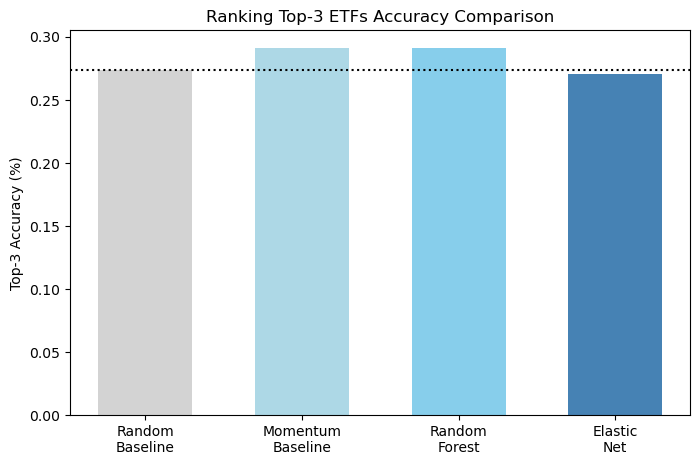

In [58]:
# top 3 accuracy comparison
models = ['Random\nBaseline', 'Momentum\nBaseline', 'Random\nForest', 'Elastic\nNet']
top3_scores = [baseline, momentum_accuracy, rf_accuracy, elnet_accuracy]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, top3_scores, width=0.6,
               color=['lightgray', 'lightblue', 'skyblue', 'steelblue'])
plt.axhline(y=baseline, color='black', linestyle=':',
            label=f'Random Baseline: {baseline:.1%}')
plt.ylabel('Top-3 Accuracy (%)')
plt.title('Ranking Top-3 ETFs Accuracy Comparison')
plt.show()

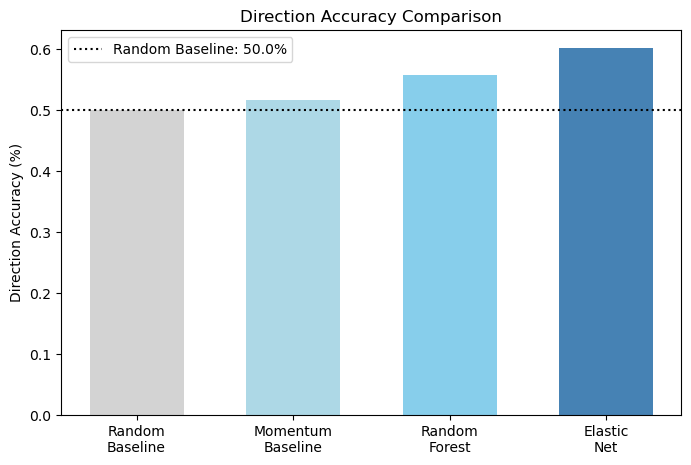

In [59]:
# direction accuracy comparison
direction_scores = [baseline_direction_accuracy, momentum_direction_accuracy,
                    rf_direction_accuracy, elnet_direction_correct]
plt.figure(figsize=(8,5))
bars = plt.bar(models, direction_scores, width=0.6,
               color=['lightgray', 'lightblue', 'skyblue', 'steelblue'])
plt.axhline(y=baseline_direction_accuracy, color='black', linestyle=':',
            label=f'Random Baseline: {baseline_direction_accuracy:.1%}')
plt.ylabel('Direction Accuracy (%)')
plt.title('Direction Accuracy Comparison')
plt.legend()
plt.show()

Result analysis & feature importance analysis

Result analysis
- Both models failed to predict which sector ETFs will be top 3
- Elastic net performed worst while random forest was on par with momentum baseline.
- This shows momentum based features might have high importance among the features.

Both models showed better direction accuracy than momentum baseline.
However, 60.1% direction accuracy by elastic net seems suspiciously high. Investigation starts here.
Need to check feature importance

In [60]:
# check SPY above 200MA counts
spy_regime = df_t2['spy_above_200ma'].value_counts()
print(spy_regime)
print(f"Percentage above 200MA: {spy_regime[1]/len(df_t2):.1%}")

spy_above_200ma
1    139
0     30
Name: count, dtype: int64
Percentage above 200MA: 82.2%


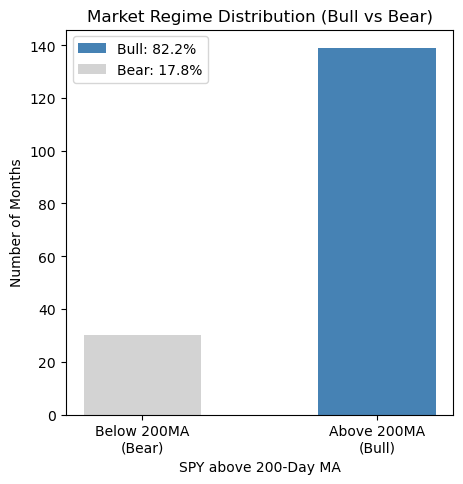

In [61]:
# SPY feature barplot
plt.figure(figsize=(5, 5))
plt.bar([1,0], spy_regime.values, color=['steelblue','lightgray'], width=.5,
        label=[f'Bull: 82.2%', f'Bear: 17.8%'])
plt.xlabel('SPY above 200-Day MA')
plt.ylabel('Number of Months')
plt.title('Market Regime Distribution (Bull vs Bear)')
plt.xticks([1,0], ['Above 200MA\n(Bull)','Below 200MA\n(Bear)'])
plt.legend()
plt.show()

- 82.2% of the time SPY was above 200MA
- Only 30 months of bear market
- 18% bear market period is not enough to create meaningful patters for random forest
- Model learned everything goes up which made regime feature useless because it was dominated by bull market
- This leads to suspicion that direction accuracy coming from bull market persistence, and not from modeling

## Part 5-1

### Random forest analysis (feature importance)

In [62]:
# feature importance
from sklearn.inspection import permutation_importance
# random forest
rf_feature_importance = rf_mod.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_feature_importance
}).sort_values('Importance', ascending=False)

print(f"Random Forest top 30 Feature Importance:")
print(rf_importance_df.head(30))

Random Forest top 30 Feature Importance:
                   Feature  Importance
0           XLE_return_63d    0.160327
5          XLF_return_252d    0.137432
3           XLE_sharpe_63d    0.086869
1          XLE_return_252d    0.067929
15          XLI_sharpe_63d    0.043689
27          XLK_sharpe_63d    0.023212
30      XLC_volatility_63d    0.019213
34      XLY_volatility_63d    0.019175
52     XLY_rank_return_63d    0.018928
28          XLC_return_63d    0.017557
11          XLV_sharpe_63d    0.017524
17         XLB_return_252d    0.017387
38      XLP_volatility_63d    0.017359
21        XLRE_return_252d    0.016302
29         XLC_return_252d    0.016211
13         XLI_return_252d    0.015546
23         XLRE_sharpe_63d    0.014505
12          XLI_return_63d    0.014459
35          XLY_sharpe_63d    0.013666
16          XLB_return_63d    0.013645
36          XLP_return_63d    0.012835
7           XLF_sharpe_63d    0.012371
56  oil_price_momentum_63d    0.011171
32          XLY_return_

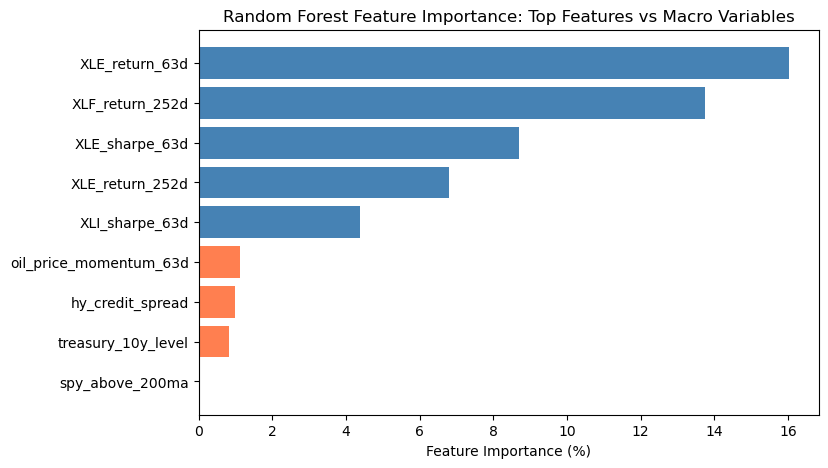

In [63]:
# random forest feature importance plot
top5_features = rf_importance_df.head(5)
macro_features = rf_importance_df[rf_importance_df['Feature'].isin([
    'hy_credit_spread','oil_price_momentum_63d',
    'treasury_10y_level','spy_above_200ma'
])]

plot_data = pd.concat([top5_features, macro_features]).drop_duplicates()

plt.figure(figsize=(8, 5))
plt.barh(plot_data['Feature'], plot_data['Importance']*100,
         color=['steelblue']*5 + ['coral']*len(macro_features))
plt.xlabel('Feature Importance (%)')
plt.title('Random Forest Feature Importance: Top Features vs Macro Variables')
plt.gca().invert_yaxis()
plt.show()

- extreme concentration on single sector, XLE, accouts more than 30% of the model's predictive power
- model is basing a huge portion of its decision on 11 sectors based on behavior of one or two sectors (XLE, XLF)
- macro features show weaker importance compared to momentum features
- regime macro feature based on SPY is completely ignored

## Part 5-2

### Elastic net analysis (feature importance)

In [64]:
# elastic net
elnet_feature_importance = np.abs(elnet_mod.coef_).mean(axis=0)
elnet_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': elnet_feature_importance
}).sort_values('Coefficient', ascending=False)

print(f"Elastic Net top 10 Feature Importance:")
print(elnet_importance_df.head(10))

Elastic Net top 10 Feature Importance:
                Feature  Coefficient
0        XLE_return_63d          0.0
44  XLE_rank_return_63d          0.0
32       XLY_return_63d          0.0
33      XLY_return_252d          0.0
34   XLY_volatility_63d          0.0
35       XLY_sharpe_63d          0.0
36       XLP_return_63d          0.0
37      XLP_return_252d          0.0
38   XLP_volatility_63d          0.0
39       XLP_sharpe_63d          0.0


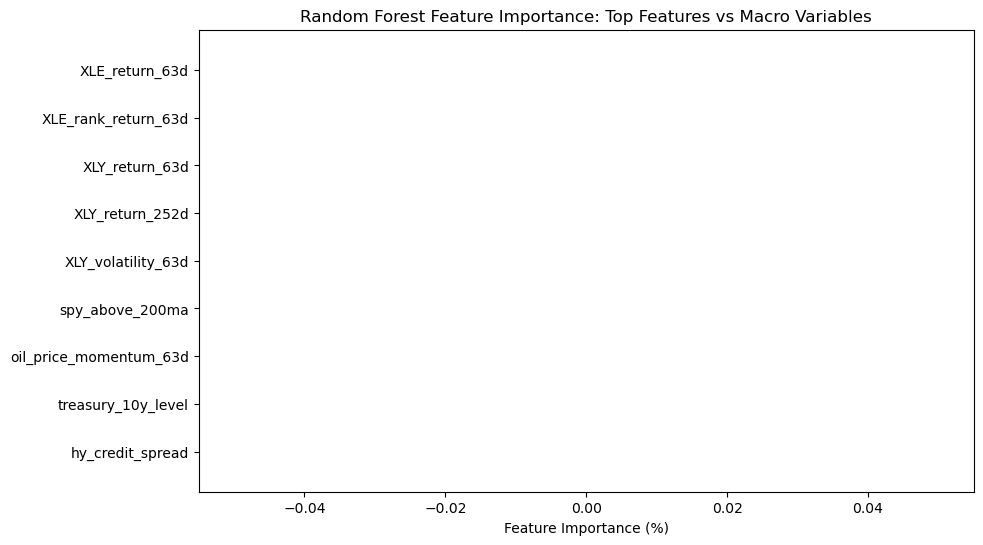

In [65]:
# elastic net feature importance plot
# blank plot
top5_features = elnet_importance_df.head(5)
macro_features = elnet_importance_df[elnet_importance_df['Feature'].isin([
    'hy_credit_spread','oil_price_momentum_63d',
    'treasury_10y_level','spy_above_200ma'
])]

plot_data = pd.concat([top5_features, macro_features]).drop_duplicates()

plt.figure(figsize=(10, 6))
plt.barh(plot_data['Feature'], plot_data['Coefficient']*100,
         color=['steelblue']*5 + ['coral']*len(macro_features))
plt.xlabel('Feature Importance (%)')
plt.title('Random Forest Feature Importance: Top Features vs Macro Variables')
plt.gca().invert_yaxis()
plt.show()

- elastic net ignored all features
- its 60% direction accuracy came from learning 82% bull market dominance


In [66]:
# elastic net positive rate
pos_pred = (elnet_pred_df > 0).sum().sum()
tot_pred = elnet_pred_df.size
pred_pos_rate = pos_pred / tot_pred
print(f"Elastic net positive predictions: {pred_pos_rate:.1%}")

Elastic net positive predictions: 97.1%


In [67]:
# positive rate by sector
print("\nPositive by sector:")
print((elnet_pred_df > 0).mean())


Positive by sector:
XLE     0.676692
XLF     1.000000
XLV     1.000000
XLI     1.000000
XLB     1.000000
XLRE    1.000000
XLK     1.000000
XLC     1.000000
XLY     1.000000
XLP     1.000000
XLU     1.000000
dtype: float64


Feature importance analysis

Random forest turns out to be energy model

The most immediate and powerful story is that Random Forest model isn't functioning as a balanced, all-sector rotation model. Instead, it has effectively become a specialized momentum model that is overwhelmingly driven by the Energy sector (XLE).

* Extreme Concentration: The top 4 features alone account for over 45% of the model's predictive power. Three of these four features belong to a single sector: XLE. The model is basing a huge portion of its decisions for all 11 sectors on the behavior of just one or two of them.
* Momentum is King: The most important features are all related to momentum (_return_63d, _return_252d) or risk-adjusted momentum (_sharpe_63d). This tells the model has learned a simple primary rule: "the best predictor of a sector's future performance is its own recent performance." This makes planned comparison against a simple momentum baseline absolutely critical.
* Macro Signals are Ignored: The model has decided that the broad macro features provided are far less important than the specific momentum of individual sectors. The model is essentially ignoring macro features.
* The model's 55% direction accuracy heavily relies on Energy sector patterns - it's not learning general market dynamics, just Energy-specific signals

The model has latched onto XLE for a few distinct reasons:
1. High Volatility and Strong Trends: The Energy sector is more volatile and cyclical than other sectors. It experiences massive booms and busts tied to the price of oil. For a tree-based model like Random Forest, this acts as very strong, clear signal (big up-trends, big down-trends) that are easy to use for splitting data and making rules.
2. Unique Driver: Unlike tech or healthcare, Energy's fate is tied directly to a single, globally traded commodity. This makes its behavior fundamentally different from the other 10 sectors, which are more closely tied to the general business cycle. This uniqueness makes it a powerful, and apparently dominant, predictive feature.

- elastic net ignored all features and predicted 97.1% positive based on its interept
- elastic net learned that, on average, sectors go up, so it predicted always up
- this explains why random forest feature importance relied heavily on XLE. XLE was the only sector with meaningful variation.


## Part 6-1

### Backtesting - random forest

In [68]:
# backtesting random forest model performance
def simple_backtest(rankings, actual_returns, top_n=3):
  # initialize an empty list to store the monthly returns
  portfolio_return = []

  # loop through each month in test period
  for i in range(len(rankings)):
    # find the names of the top 3 sectors for this month
    top_sectors = rankings.iloc[i].nsmallest(top_n).index
    # equal weight portfolio return for this month
    month_return = actual_returns.iloc[i][top_sectors].mean()
    portfolio_return.append(month_return)

  return pd.Series(portfolio_return, index=rankings.index)

In [69]:
# random forest portfolio backtest
rf_portfolio_returns = simple_backtest(rf_rankings, actual_returns_df, top_n=3)

rf_annual_return = rf_portfolio_returns.mean() * 12
rf_volatility = rf_portfolio_returns.std() * np.sqrt(12)
rf_sharpe_ratio = rf_annual_return / rf_volatility

print(f"Random Forest Portfolio Performance:")
print(f"Annualized Return: {rf_annual_return:.1%}%")
print(f"Annualized Volatility: {rf_volatility:.1%}%")
print(f"Sharpe Ratio: {rf_sharpe_ratio:.2f}")

Random Forest Portfolio Performance:
Annualized Return: 11.2%%
Annualized Volatility: 15.6%%
Sharpe Ratio: 0.72


In [70]:
# baseline result (investing SPY only without sector rotation)
# SPY data setup
spy_df = pd.DataFrame({
    'SPY': df_data['SPY'],
    'spy_return_21d_forward': np.log(df_data['SPY'].shift(-21) / df_data['SPY'])
}, index=df_data.index)

# merge spy_df into df_clean
df_clean_with_spy = df_clean.merge(spy_df, left_index=True, right_index=True,
                                   how='left')

# create T-2 dataset with new dataset
month_ends = df_clean_with_spy.resample('BM').last().index
t2_dates = month_ends - pd.tseries.offsets.BDay(2)
df_t2_with_spy = df_clean_with_spy.loc[df_clean_with_spy.index.isin(t2_dates)]

# SPY only backtest
spy_returns_backtest = df_t2_with_spy['spy_return_21d_forward'].loc[rf_portfolio_returns.index]


spy_annual_return = spy_returns_backtest.mean() * 12
spy_volatility = spy_returns_backtest.std() * np.sqrt(12)
spy_sharpe_ratio = spy_annual_return / spy_volatility
print(f"SPY data shape: {spy_returns_backtest.shape}")
print(f"First date: {spy_returns_backtest.index.date[0]}")
print(f"Last date: {spy_returns_backtest.index.date[-1]}")

SPY data shape: (133,)
First date: 2014-02-26
Last date: 2025-06-26


In [71]:
# SPY performance metrics
print("SPY Benchmark Performance:")
print(f"Annualized Return: {spy_annual_return:.1%}")
print(f"Annualized Volatility: {spy_volatility:.1%}")
print(f"Sharpe Ratio: {spy_sharpe_ratio:.2f}")

print("\nComparison:")
print("Random Forest vs SPY:")
print(f"RF Return: {rf_annual_return:.1%} vs SPY Return: {spy_annual_return:.1%}")

SPY Benchmark Performance:
Annualized Return: 12.2%
Annualized Volatility: 15.2%
Sharpe Ratio: 0.80

Comparison:
Random Forest vs SPY:
RF Return: 11.2% vs SPY Return: 12.2%


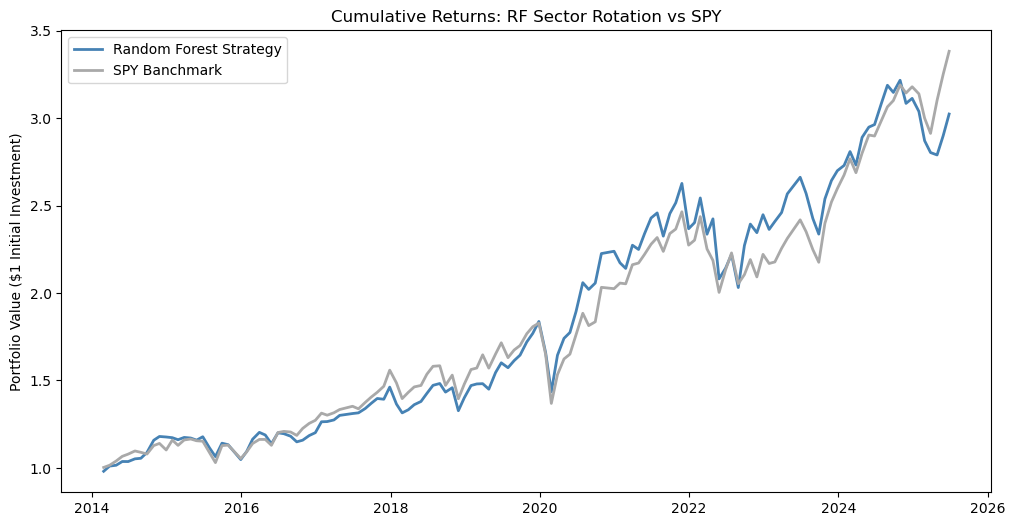

In [72]:
# RF vs SPY buy and hold ($1 initial investment)
plt.figure(figsize=(12,6))

rf_cumulative = (1 + rf_portfolio_returns).cumprod()
spy_cumulative = (1 + spy_returns_backtest).cumprod()

plt.plot(rf_cumulative, label='Random Forest Strategy', color='steelblue',
         linewidth=2)
plt.plot(spy_cumulative, label='SPY Banchmark', color='darkgray',
         linewidth=2)
plt.title('Cumulative Returns: RF Sector Rotation vs SPY')
plt.ylabel('Portfolio Value ($1 Initial Investment)')
plt.legend()
plt.show()

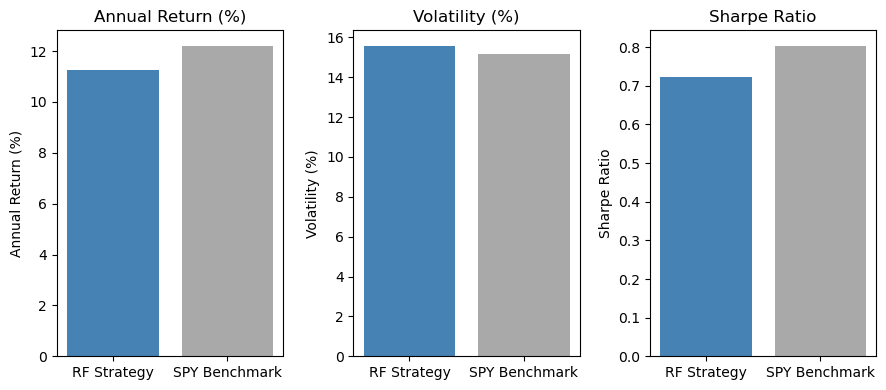

In [73]:
rf_metrics_data = pd.DataFrame({
    'Random Forest': [rf_annual_return*100, rf_volatility*100, rf_sharpe_ratio],
    'SPY Benchmark': [spy_annual_return*100, spy_volatility*100, spy_sharpe_ratio]
}, index=['Annual Return (%)','Volatility (%)','Sharpe Ratio'])

fig, ax = plt.subplots(1,3, figsize=(9,4))

for i, metric in enumerate(rf_metrics_data.index):
  ax[i].bar(['RF Strategy', 'SPY Benchmark'], rf_metrics_data.iloc[i],
            color=['steelblue', 'darkgray'], width=.8)
  ax[i].set_title(metric)
  ax[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

- random forest sector rotation strategy shows slightly higher performance than buy and hold SPY strategy.
- however, the difference is too small to trade off transaction cost and expenses. cost of buying and selling sector ETFs every month would far exceed cost of just buying and holding SPY.

## Part 6-2

### Backtesting - elastic net

In [74]:
# elastic net portfolio backtest
en_portfolio_returns = simple_backtest(elnet_rankings, actual_returns_df, top_n=3)

en_annual_return = en_portfolio_returns.mean() * 12
en_volatility = en_portfolio_returns.std() * np.sqrt(12)
en_sharpe_ratio = en_annual_return / en_volatility

print(f"Elastic Net Portfolio Performance:")
print(f"Annualized Return: {en_annual_return:.1%}")
print(f"Annualized Volatility: {en_volatility:.1%}")
print(f"Sharpe Ratio: {en_sharpe_ratio:.2f}")

Elastic Net Portfolio Performance:
Annualized Return: 10.6%
Annualized Volatility: 15.3%
Sharpe Ratio: 0.69


In [75]:
# SPY performance metrics
print("SPY Benchmark Performance:")
print(f"Annualized Return: {spy_annual_return:.1%}")
print(f"Annualized Volatility: {spy_volatility:.1%}")
print(f"Sharpe Ratio: {spy_sharpe_ratio:.2f}")

print("\nComparison:")
print("Random Forest vs SPY:")
print(f"RF Return: {en_annual_return:.1%} vs SPY Return: {spy_annual_return:.1%}")

SPY Benchmark Performance:
Annualized Return: 12.2%
Annualized Volatility: 15.2%
Sharpe Ratio: 0.80

Comparison:
Random Forest vs SPY:
RF Return: 10.6% vs SPY Return: 12.2%


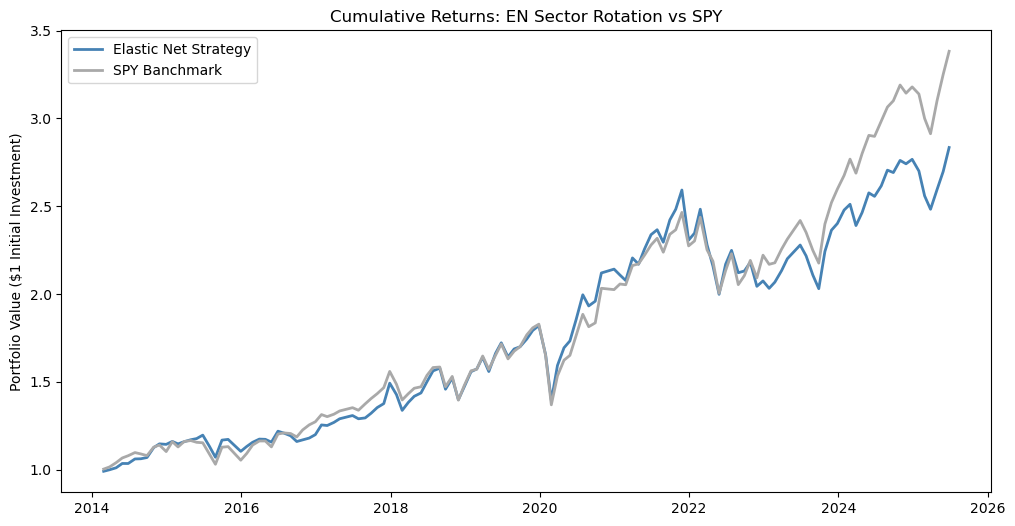

In [76]:
# EN vs SPY buy and hold ($1 initial investment)
plt.figure(figsize=(12,6))

en_cumulative = (1 + en_portfolio_returns).cumprod()
spy_cumulative = (1 + spy_returns_backtest).cumprod()

plt.plot(en_cumulative, label='Elastic Net Strategy', color='steelblue',
         linewidth=2)
plt.plot(spy_cumulative, label='SPY Banchmark', color='darkgray',
         linewidth=2)
plt.title('Cumulative Returns: EN Sector Rotation vs SPY')
plt.ylabel('Portfolio Value ($1 Initial Investment)')
plt.legend()
plt.show()

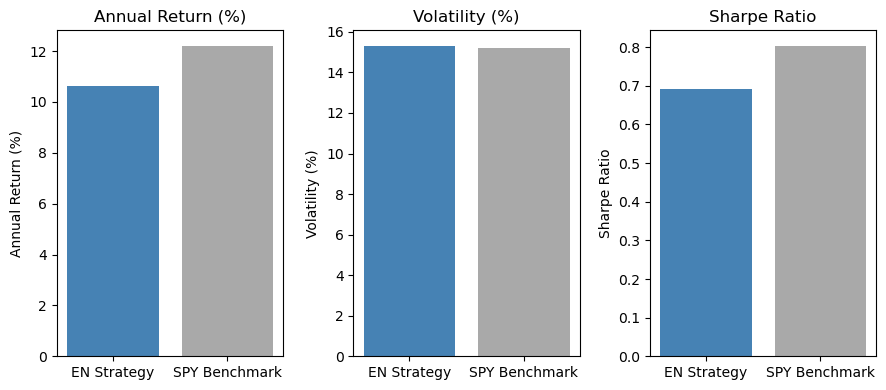

In [77]:
en_metrics_data = pd.DataFrame({
    'Elastic Net': [en_annual_return*100, en_volatility*100, en_sharpe_ratio],
    'SPY Benchmark': [spy_annual_return*100, spy_volatility*100, spy_sharpe_ratio]
}, index=['Annual Return (%)','Volatility (%)','Sharpe Ratio'])

fig, ax = plt.subplots(1,3, figsize=(9,4))

for i, metric in enumerate(en_metrics_data.index):
  ax[i].bar(['EN Strategy', 'SPY Benchmark'], en_metrics_data.iloc[i],
            color=['steelblue', 'darkgray'], width=.8)
  ax[i].set_title(metric)
  ax[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

- Elastic net sector rotation underperformed SPY buy and hold strategy.

In [78]:
# EN direction backtesting
def direction_backtest(predictions_df, spy_returns):
    portfolio_returns = []
    for i in range(len(predictions_df)):
      avg_prediction = predictions_df.iloc[i].mean()
      if avg_prediction > 0:
        month_return = spy_returns.iloc[i]
      else:
        month_return = 0.0

      portfolio_returns.append(month_return)

    return pd.Series(portfolio_returns, index=predictions_df.index)

In [79]:
en_direction_portfolio = direction_backtest(elnet_pred_df, spy_returns_backtest)

en_direction_annual = en_direction_portfolio.mean() * 12
en_direction_volatility = en_direction_portfolio.std() * np.sqrt(12)
en_direction_sharpe = en_direction_annual / en_direction_volatility

print(f"Elastic Net Direction Strategy Performance:")
print(f"Annualized Return: {en_direction_annual:.1%}")
print(f"Annualized Volatility: {en_direction_volatility:.1%}")
print(f"Sharpe Ratio: {en_direction_sharpe:.2f}")

Elastic Net Direction Strategy Performance:
Annualized Return: 12.2%
Annualized Volatility: 15.2%
Sharpe Ratio: 0.80


In [80]:
# compare all EN strategies against SPY buy and hold
direction_comparison = pd.DataFrame({
    'EN Direction Strategy': [en_direction_annual*100, en_direction_volatility*100, en_direction_sharpe],
    'SPY Buy-and-Hold': [spy_annual_return*100, spy_volatility*100, spy_sharpe_ratio],
    'EN Sector Rotation': [en_annual_return*100, en_volatility*100, en_sharpe_ratio]
}, index=['Annual Return (%)', 'Volatility (%)', 'Sharpe Ratio'])

print("Strategy Comparison:")
print(direction_comparison)

Strategy Comparison:
                   EN Direction Strategy  SPY Buy-and-Hold  EN Sector Rotation
Annual Return (%)              12.207170         12.207170           10.610824
Volatility (%)                 15.191647         15.191647           15.308796
Sharpe Ratio                    0.803545          0.803545            0.693119


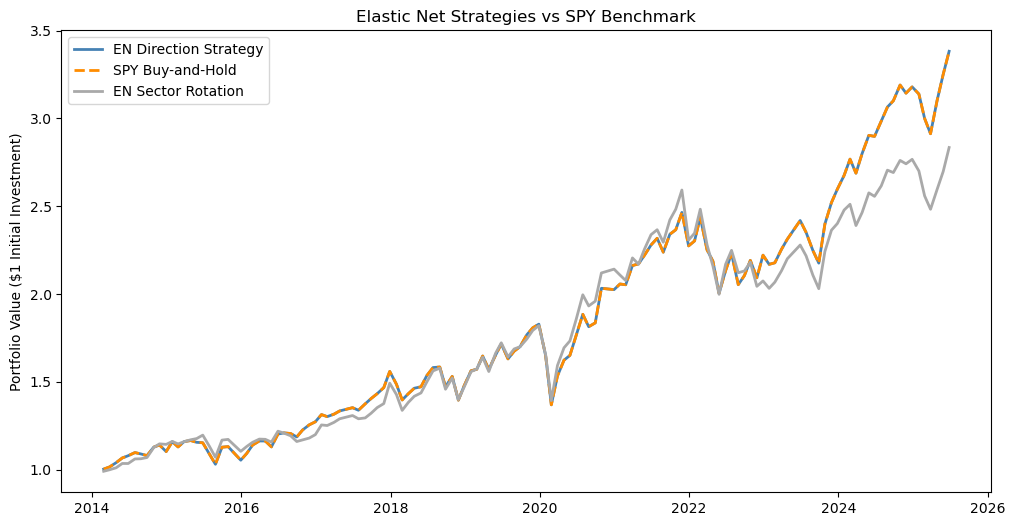

In [81]:
# EN strategies vs SPY buy and hold ($1 initial investment)
plt.figure(figsize=(12, 6))

en_direction_cumulative = (1 + en_direction_portfolio).cumprod()
spy_cumulative = (1 + spy_returns_backtest).cumprod()
en_sector_cumulative = (1 + en_portfolio_returns).cumprod()

plt.plot(en_direction_cumulative.index, en_direction_cumulative.values,
         label='EN Direction Strategy', linewidth=2, color='steelblue')
plt.plot(spy_cumulative.index, spy_cumulative.values,
         label='SPY Buy-and-Hold', linewidth=2, color='darkorange', linestyle='--')
plt.plot(en_sector_cumulative.index, en_sector_cumulative.values,
         label='EN Sector Rotation', linewidth=2, color='darkgray')

plt.title('Elastic Net Strategies vs SPY Benchmark')
plt.ylabel('Portfolio Value ($1 Initial Investment)')
plt.legend()
plt.show()

- elastic net's superior direction accuracy turned out tobe meaningless - it just learned to always predict 'up' during a bull market period. the resulting market timing strategy was identical to passive buy and hold SPY stragety.
- model learned environment bias and no predictive signals
- both en strategies failed - one underperformed, the other just identical to the benchmark whild paying additional expense cost.
- random forest direction strategy likely similar since both models learned bull market bias.

## Conclusion

### Lessons learned

- engineer more sophisticated macro features
 - momentum features work better than macro features for short term prediction
 - cross-sectional ranking features didn't help as expected
 - time horizon mismatch; macro trends need longer time horizon
- might have discovered energy sector predictable model
 - results revealed that XLE momentum and volatility patterns are learnable
 - energy sector behaves differently from other sectors
- market regime matters
 - 82% bull market is a crucial and decisive factor
 - proves importance of testing models across different market conditions
 - reveals how models can learn environmental bias

### Limitation of current approach

- exposing model to broader market history 
- acquiring more and richer data

### Future research/work

- engineer more sohpisticated features with given data (unlikely change the model performance)
- develop a strategy focused on a smaller, less correlated portfolio of sectors
- build a dedicated model for the energy sector (XLE) to leverage its strong patterns
- complete new idea: model predicting volatility